# Sandbox/demo to go along with the MD assignment and lectures

## PharmSci 175/275
Author: David Mobley




## Preparation 

To use this notebook you will either need to run it locally using Jupyter or on Google Colab. To run this notebook you will need the OpenEye toolkits installed, as well as the OpenFF toolkits (`openff-toolkit`), `openmm`, and other libraries. If you installed these in a local environment during prep for the class, you should already be prepared; if you are using Google Colab, you will need to install them here. 

### Preparation for Google Colab (NOT FOR LOCAL USE)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/MD/MD_Sandbox_Molecule.ipynb)

For Google Colab, we'll use `conda` for installation because it will work better with packaging for OpenFF and OpenMM.  Begin by unsetting the PYTHONPATH to prevent issues with miniconda, then installing miniconda (which will take perhaps 20 seconds to a couple of minutes):

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


**WAIT FOR THAT TO FINISH BEFORE RUNNING ANY OTHER CELLS**; it actually needs to get to the point where it finishes AND RESTARTS YOUR KERNEL before you can continue running additional cells.

Once that is done, install the OpenEye toolkits:

In [1]:
!mamba install -c openeye openeye-toolkits --yes


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['openeye-toolkits']

conda-forge/linux-64     [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 2

Next, mount your Google Drive, which you will need at least for your OpenEye license:

In [2]:
# Run cell if using collab

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Prep OpenEye license and check: 

In [3]:
license_filename = '/content/drive/MyDrive/oe_license.txt'
import openeye

import os
if os.path.isfile(license_filename):
  license_file = open(license_filename, 'r')
  openeye.OEAddLicenseData(license_file.read())
  license_file.close()
else:
  print("Error: Your OpenEye license is not readable; please check your filename and that you have mounted your Google Drive")

licensed = openeye.oechem.OEChemIsLicensed()
print("Was your OpenEye license correctly installed (True/False)? " + str(licensed))
if not licensed:
  print("Error: Your OpenEye license is not correctly installed.")
  raise Exception("Error: Your OpenEye license is not correctly installed.")

Was your OpenEye license correctly installed (True/False)? True


#### Now(for Colab) we conda install the other prerequisites

In [12]:
!mamba install -c conda-forge openff-toolkit openmm nglview --yes


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  pkgs/main linux-64
Getting  pkgs/main noarch
Getting  pkgs/r

### Preparation for local use

For local use, you need to ensure you are operating in a Python environment with the OpenEye toolkits (and license), the `openff-toolkit`, and `openmm`, the latter two of which are available from conda-forge.

# Now let's do MD on a molecule!

In the other sandbox associated with this lecture, we did some very simple MD on a 1D Lennard-Jones system. Now let's head towards the opposite extreme and do our first molecular system.

Here, we'll draw on OpenMM, a molecular mechanics toolkit we'll see again later in the class, for running some simple energy minimizations and molecular dynamics. And we'll use the `openforcefield` tools for assigning a force field for a molecule, because they make this very simple (and you have them already installed).

## First, we generate a molecule

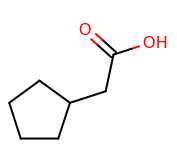

In [5]:
#@title
# What SMILES string for the guest? Should be isomeric SMILES
mol_smiles = 'OC(CC1CCCC1)=O'

# Import stuff
from openeye.oechem import *
from openeye.oeomega import * # conformer generation
from openeye.oequacpac import * #for partial charge assignment

# Create empty OEMol
mol = OEMol()
# Convert SMILES
OESmilesToMol(mol, mol_smiles)

# Draw to make sure that's what we want
from IPython.display import Image
import openeye.oedepict as oedepict # Use OpenEye depiction toolkit
oedepict.OEPrepareDepiction(mol)
oedepict.OERenderMolecule("DepictMolSimple.png", mol)
Image('DepictMolSimple.png',width = 200)

## For some use cases, we would begin with a structure of our molecule

We're about to jump into the OpenFF toolkit and prep our molecule for simulation. We could either begin with the molecule in a format which had coordinates (like .mol2 or .sdf) if we were starting from a conformer we wanted to use, or we could let the toolkit generate a conformer for us. Here, since we aren't starting with a conformer we want to use, we will let the toolkit generate an initial conformer. 

## We apply a force field to assign parameters to the system

This uses the `openff-toolkit` from Open Force Field, along with the `openff-2.0.0` Parsley force field.

In [7]:
from openff.toolkit.topology import Topology, Molecule
from openff.toolkit.typing.engines.smirnoff import ForceField
from openmm import unit

# Get force field ready
ff = ForceField('openff-2.0.0.offxml')

# Generate an OpenFF molecule from the SMILES
offmol = Molecule.from_smiles(mol_smiles)

# Generate a conformer, using whatever cheminformatics "backend" the toolkit is using (OpenEye or RDKit in general; here OpenEye)
offmol.generate_conformers(n_conformers=1)

# Draw the OpenFF molecule to make sure it looks OK
offmol.visualize()

# Create an empty OpenFF Topology 
topology = Topology()

# Add our molecule to the Topology (a Topology can contain multiple molecules)
molecule_topology_indices = topology.add_molecule(offmol)

#Place in 4 nm box
import numpy as np
topology.box_vectors = np.eye(3) * 4 * unit.nanometer

# Parametrize the topology and create an OpenMM System.
system = ff.create_openmm_system(topology)

# Generate OpenMM topology for use setting up simulation
omm_topology = topology.to_openmm()

# Write to a file for convenience
offmol.to_file('molecule.mol2', file_format='mol2')

## Next we'll start off by doing an energy minimization

We first prepare the system, but then the actual energy minimization is very simple. I believe OpenMM is using an L-BFGS minimizer.

In [8]:
# Import openmm stuff
import openmm
try:
    import openmm
    from openmm import unit
except ImportError:
    from simtk import openmm, unit

# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = openmm.app.Simulation(omm_topology, system, integrator)

# Copy in the positions - here we use those from the OpenFF molecule we generated, but they could come from elsewhere
positions = offmol.conformers[0]
simulation.context.setPositions( positions) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

Energy before minimization (kcal/mol): 19
Energy after minimization (kcal/mol): 16


## Now we do some bookkeeping to run MD

Most of this is just setup, file bookkeeping, temperature selection, etc. The key part which actually runs it is the second-to-last block of code which says `simulation.step(1000)` which runs 1000 steps of dynamics. The timestep for this is set near the top, and is 2 femtoseconds per timestep, so the total time is 2000 fs, or 2 ps.

Simulation snapshots are stored to a NetCDF file for later visualization, every 100 frames (so we'll end up with 10 of them). You can adjust these settings if you like.

In [25]:
import os
from datetime import datetime
from mdtraj import reporters

# Propagate the System with Langevin dynamics.
time_step = 2 * unit.femtoseconds  # simulation timestep
temperature = 300 * unit.kelvin  # simulation temperature
friction = 1 / unit.picosecond  # collision rate
integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

# Length of the simulation.
num_steps = 1000  # number of integration steps to run

# Prep Simulation
simulation = openmm.app.Simulation(omm_topology, system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(temperature)

# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(openmm.app.StateDataReporter(os.path.join('.', 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))
netcdf_reporter = reporters.NetCDFReporter(os.path.join('.', 'trajectory.nc'), 100) #Store every 100 frames
simulation.reporters.append(netcdf_reporter)
# Also store to a PDB for convenience
pdb_reporter = openmm.app.PDBReporter("trajectory.pdb", 100) #store every 100 steps
simulation.reporters.append(pdb_reporter)

# Run the simulation and print start info; store timing
print("Starting simulation")
start = datetime.now()
simulation.step(num_steps) 
end = datetime.now()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds" % (end-start).total_seconds())
netcdf_reporter.close()
print("Done!")


Starting simulation
Elapsed time 2.85 seconds
Done!


## Now we can visualize the results with `nglview`

If you don't have `nglview`, you can also load the PDB file, `molecule.mol2`, with a standard viewer like VMD or Chimera, and then load the PDB trajectory file (`trajectory.pdb`) in afterwards. If `nglview` is not working on your platform, you can use `py3dmol` to load a static view of structures.

Currently nglview seems to be RUNNING on Colab but doesn't result in trajectories which look correct.

In [18]:
#COLAB ONLY: First enable third party widgets
from google.colab import output
output.enable_custom_widget_manager()

In [26]:
# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
import mdtraj
import nglview
traj= mdtraj.load(os.path.join('.', 'trajectory.nc'), top=os.path.join('.', 'molecule.mol2'))

# View the trajectory
view = nglview.show_mdtraj(traj)
view

NGLWidget(max_frame=9)

## Exercises

- Try your own molecule. What about one which has the potential for internal hydrogen bonding?
- Run the dynamics longer
- What is different if you lower the temperature? Raise the temperature? 

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()